<a href="https://colab.research.google.com/github/khwaish-byte/24f1002327_git_challenge_lab/blob/main/load_forecasting_using_XGBoost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# --- Data Creation (Replace with your own data loading) ---
# Let's create a sample dataframe that mimics a real-world dataset.
# If you have a CSV, you would use: df = pd.read_csv('your_data.csv')
date_rng = pd.date_range(start='2022-01-01', end='2023-01-01', freq='h')
data = {
    'datetime': date_rng,
    # Create some synthetic data with daily and weekly seasonality
    'energy_consumption_MW': 100
                           + 10 * np.sin(2 * np.pi * date_rng.hour / 24)
                           + 5 * np.sin(2 * np.pi * date_rng.dayofweek / 7)
                           + np.random.randn(len(date_rng)) * 2
}
df = pd.DataFrame(data)
df.set_index('datetime', inplace=True)

print("Original Data Head:")
print(df.head())

Original Data Head:
                     energy_consumption_MW
datetime                                  
2022-01-01 00:00:00              93.730246
2022-01-01 01:00:00              97.365548
2022-01-01 02:00:00              99.180206
2022-01-01 03:00:00             104.802874
2022-01-01 04:00:00             103.852516


In [3]:
# 2. Feature Enigneering

In [4]:
def create_time_features(df):
    """
    Creates time series features from a datetime index.
    """
    df_copy = df.copy()
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek  # Monday=0, Sunday=6
    df_copy['quarter'] = df_copy.index.quarter
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year
    df_copy['dayofyear'] = df_copy.index.dayofyear
    return df_copy

df = create_time_features(df)
print("\nData with Time Features:")
print(df.head())


Data with Time Features:
                     energy_consumption_MW  hour  dayofweek  quarter  month  \
datetime                                                                      
2022-01-01 00:00:00              93.730246     0          5        1      1   
2022-01-01 01:00:00              97.365548     1          5        1      1   
2022-01-01 02:00:00              99.180206     2          5        1      1   
2022-01-01 03:00:00             104.802874     3          5        1      1   
2022-01-01 04:00:00             103.852516     4          5        1      1   

                     year  dayofyear  
datetime                              
2022-01-01 00:00:00  2022          1  
2022-01-01 01:00:00  2022          1  
2022-01-01 02:00:00  2022          1  
2022-01-01 03:00:00  2022          1  
2022-01-01 04:00:00  2022          1  


In [5]:
# We will use the last month of data as our test set
split_date = '2022-12-01'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Define features (X) and target (y)
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'energy_consumption_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (8016, 6)
Test data shape: (745, 6)


In [6]:
# Create and train the XGBoost model
# n_estimators is the number of trees in the model
# learning_rate controls how much each tree corrects the previous one
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=10, # Stop training if validation score doesn't improve
    eval_metric='rmse'
)

# The model will be evaluated on the test set during training to find the best tree
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100) # Print progress every 100 rounds

# Make predictions on the test set
test['prediction'] = reg.predict(X_test)

[0]	validation_0-rmse:8.10822	validation_1-rmse:8.02222
[100]	validation_0-rmse:3.65668	validation_1-rmse:3.59691
[200]	validation_0-rmse:2.34924	validation_1-rmse:2.34339
[300]	validation_0-rmse:2.03911	validation_1-rmse:2.09281
[400]	validation_0-rmse:1.96826	validation_1-rmse:2.05724
[461]	validation_0-rmse:1.95105	validation_1-rmse:2.05519


/tmp/ipython-input-3619493343.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)



Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.66
Root Mean Squared Error (RMSE): 2.05
R-squared (R²): 0.94


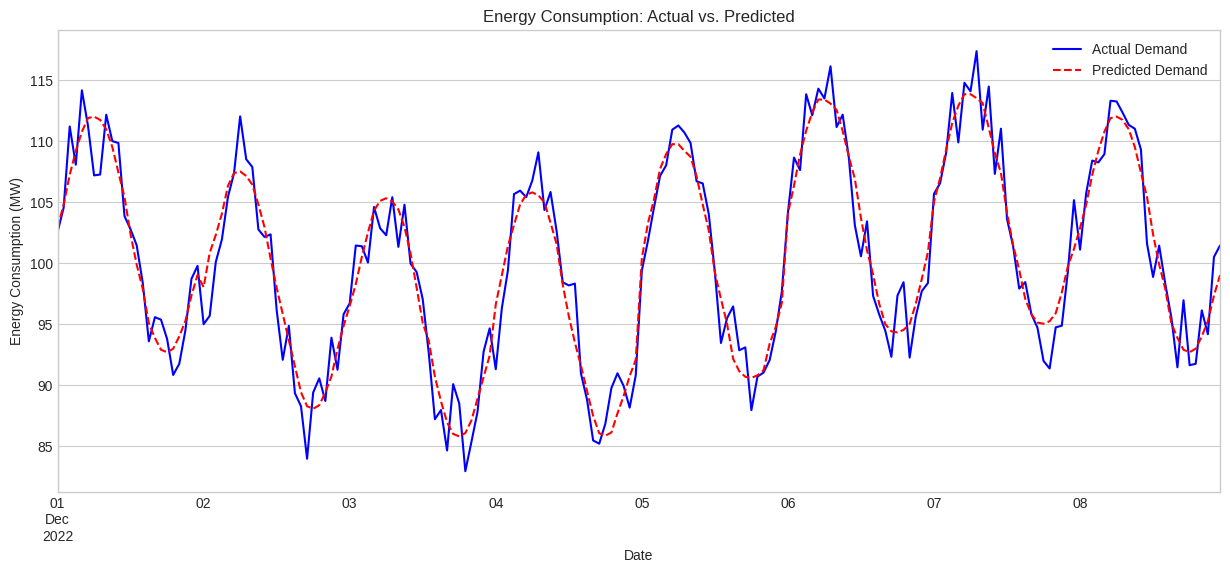

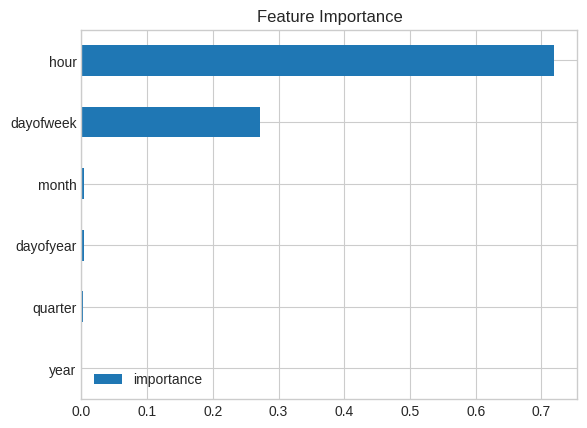

In [7]:
# Calculate evaluation metrics
mae = mean_absolute_error(test[TARGET], test['prediction'])
rmse = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
r2 = r2_score(test[TARGET], test['prediction'])

print(f"\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Visualize the predictions vs actuals
# We'll plot just one week of the test data for better visibility
plot_start_date = '2022-12-01'
plot_end_date = '2022-12-08'

fig, ax = plt.subplots(figsize=(15, 6))
test.loc[plot_start_date:plot_end_date, TARGET].plot(ax=ax, label='Actual Demand', color='blue')
test.loc[plot_start_date:plot_end_date, 'prediction'].plot(ax=ax, label='Predicted Demand', color='red', linestyle='--')
ax.set_title('Energy Consumption: Actual vs. Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (MW)')
ax.legend()
plt.show()

# You can also check feature importance
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=reg.feature_names_in_,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()